# Xopt Evaluator Basic Usage 

In [1]:
# needed for macos
import platform
if platform.system() == 'Darwin':
    import multiprocessing as mp                                                                                     
    mp.set_start_method("fork")    


In [2]:
from xopt import XoptBase, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.evaluator import DummyExecutor
import numpy as np
import pandas as pd
from time import sleep
from random import randint

In [3]:

vocs = VOCS(variables = {'x': [0,1], 'y': [0,1]}, objectives = {'f1':'MINIMIZE'})

def f(inputs):

    sleep(randint(1, 5)) # simulate computation time
    # Make some occasional errors
    if inputs['x'] > 0.8:
        raise ValueError('x > 0.8')

    return {'f1': inputs['x']**2 + inputs['y']**2}

in1 = vocs.random_inputs()
f(in1)

{'f1': 0.4086837156158182}

In [4]:
X = XoptBase(RandomGenerator(vocs), Evaluator(f), vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
0,0.052266,0.911927
1,0.053366,0.435781
2,0.141128,0.730097
3,0.209750,0.898470


In [5]:
# Internal futures dictionary
X._futures

{0: <Future at 0x22b12435430 state=finished returned dict>,
 1: <Future at 0x22b12416bb0 state=finished returned dict>,
 2: <Future at 0x22b12416af0 state=finished returned dict>,
 3: <Future at 0x22b07c0dd30 state=finished returned dict>}

In [6]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.052266,0.911927,0.834343,False,
1,0.053366,0.435781,0.192753,False,
2,0.141128,0.730097,0.552959,False,
3,0.209750,0.898470,0.851243,False,


In [7]:
# Futures are now cleared out
X._futures

{}

In [8]:
# This is the internal counter
X._ix_last

3

In [9]:
X.submit_data(vocs.random_inputs(4))
X._input_data 

,x,y
4,0.096862,0.280273
5,0.961302,0.713356
6,0.650298,0.742039
7,0.296161,0.198052


In [10]:
X._futures

{4: <Future at 0x22b1247caf0 state=finished returned dict>,
 5: <Future at 0x22b12435be0 state=finished raised ValueError>,
 6: <Future at 0x22b12416c40 state=finished returned dict>,
 7: <Future at 0x22b12435fd0 state=finished returned dict>}

In [11]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.052266,0.911927,0.834343,False,
1,0.053366,0.435781,0.192753,False,
2,0.141128,0.730097,0.552959,False,
3,0.209750,0.898470,0.851243,False,
4,0.096862,0.280273,0.087935,False,
5,0.961302,0.713356,NaN,True,"Traceback (most recent call last):\n File ""C:..."
6,0.650298,0.742039,0.973510,False,
7,0.296161,0.198052,0.126936,False,
8,0.901273,0.438690,NaN,True,"Traceback (most recent call last):\n File ""C:..."


# Executors

In [12]:
from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging

In [13]:
MAX_WORKERS =10

In [14]:
# Dask
#client = Client( silence_logs=logging.ERROR)
#executor = client.get_executor()
#client

In [15]:
executor = ThreadPoolExecutor(max_workers=MAX_WORKERS)
#executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [16]:
X2 = XoptBase(RandomGenerator(vocs), Evaluator(f, executor=executor, max_workers=MAX_WORKERS), 
    vocs,
    asynch=True)

In [17]:
for _ in range(20):
    X2.step()
    X2.update_data()


<AxesSubplot:xlabel='x', ylabel='y'>

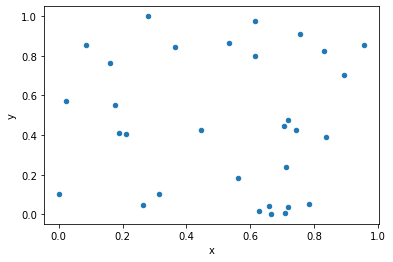

In [18]:
X2.data.plot.scatter('x', 'y')